<a href="https://colab.research.google.com/github/aldisstar/Taller-MIT/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise, we'll learn how to build various types of neural networks for regression and classification tasks

Reference for PyTorch NN module: https://pytorch.org/docs/stable/nn.html

# Build a Neural Network!




In [ ]:
# ==============================================
# 0. Module imports
# ==============================================

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

# data manipulation
import pandas as pd
import numpy as np
import scipy.stats as st
import scipy

# plots
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl

# classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# dimension reduction
from sklearn.decomposition import PCA
#from sklearn.datasets import load_boston

# cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection

# parallel processing
from joblib import Parallel, delayed
import multiprocessing

# model evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

device = "cpu"

Some visualization code. Don't forget to run it!

In [1]:
#@title

from graphviz import Digraph

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
def visualize(model):
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    # custom script to get all the shapes of a network's layers
    sizes = list()
    state_dict = net.state_dict()
    for idx, key in enumerate(state_dict.keys()):
      if key.endswith('weight'):
        output_size, input_size = state_dict[key].shape
        if idx == 0:
          sizes.append(input_size)
        sizes.append(output_size)

    input_layer = sizes[0]
    for layer in layers:
        if layer == layers[0]:
            hidden_layers.append(layer.out_features)

        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers.append(layer.out_features)

        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename='visualization_tmp')
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
          c.attr(color="white")
          for i in range(0, sizes[0]):
              n += 1
              c.node(str(n))
              c.attr(labeljust="1")
              c.attr(label="Input Layer", labelloc="bottom")
              c.attr(rank="same")
              c.node_attr.update(
                  width="0.65",
                  style="filled",
                  shape="circle",
                  color=HAPPY_COLORS_PALETTE[3],
                  fontcolor=HAPPY_COLORS_PALETTE[3],
              )
    for layer_idx in range(0, len(sizes) - 2):
        with g.subgraph(name="cluster_" + str(layer_idx + 1)) as c:
            c.attr(color="white")
            c.attr(rank="same")
            label = f'Hidden Layer {layer_idx + 1}'
            c.attr(labeljust="right", labelloc="b", label=label)
            for j in range(0, hidden_layers[layer_idx]):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[0],
                    fontcolor=HAPPY_COLORS_PALETTE[0],
                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            last_layer_nodes = hidden_layers[layer_idx]
            nodes_up += hidden_layers[layer_idx]

    with g.subgraph(name="cluster_output") as c:
        c.attr(color="white")
        c.attr(rank="same")
        c.attr(labeljust="1")
        for i in range(1, output_layer + 1):
            n += 1
            c.node(
                str(n),
                width="0.65",
                shape="circle",
                style="filled",
                color=HAPPY_COLORS_PALETTE[4],
                fontcolor=HAPPY_COLORS_PALETTE[4],

            )
            for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                g.edge(str(h), str(n))
        c.attr(label="Output Layer", labelloc="bottom")
        c.node_attr.update(
            color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
        )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    g.view()
    return g

# Section 1: NNs for regression

## Boston housing dataset

The **[Boston House Prices Regression dataset](https://www.machinecurve.com/index.php/2019/12/31/exploring-the-keras-datasets/#boston-housing-price-regression-dataset)** contains 506 observations that relate certain characteristics with the price of houses (in $1000s) in Boston in some period.

Some observations about this data (from [this article](https://www.machinecurve.com/index.php/2019/12/31/exploring-the-keras-datasets/#boston-housing-price-regression-dataset)):

The minimum house price is $5000, while the maximum house price is $50000. This may sound weird, but it’s not: house prices have risen over the decades, and the study that produced this data is from 1978 (Harrison & Rubinfeld, 1978). Actually, around 1978 prices of ≈$50.000 were quite the median value, so this dataset seems to contain relatively cheaper houses (or the Boston area was cheaper back then – I don’t know; Martin, 2017).

The mean house price was $22.533.

Variance in house prices is $84.587.

These are variables available in the dataset:

**CRIM** per capita crime rate by town

**ZN** proportion of residential land zoned for lots over 25,000 sq.ft.

**INDUS** proportion of non-retail business acres per town

**CHAS** Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

**NOX** nitric oxides concentration (parts per 10 million)

**RM** average number of rooms per dwelling

**AGE** proportion of owner-occupied units built prior to 1940

**DIS** weighted distances to five Boston employment centres

**RAD** index of accessibility to radial highways

**TAX** full-value property-tax rate per $10,000

**PTRATIO** pupil-teacher ratio by town

**LSTAT** % lower status of the population

**MEDV** Median value of owner-occupied homes in $1000’s

Obviously, **MEDV** is the median value and hence the target variable.

Note: the dataset used in this exercise was modified from the original after it was depreciated in scikit-learn for ethical reasons. We have removed the variable "B" which had information about racial differences by town. Please see more information from scikit learn here: https://scikit-learn.org/1.0/modules/generated/sklearn.datasets.load_boston.html. This dataset should be used to understand neural net functionality only.

### Load Boston dataset from Scikit-learn

In [ ]:
# Download the dataset
BostonHousing = pd.read_csv('boston_house_prices.csv')
display(BostonHousing.head(10))
features = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "LSTAT"]
label = ["MEDV"]
BostonHousing = BostonHousing.filter(features + label)
X, y = BostonHousing[features], BostonHousing[label]

# No. of features for input (num_features)
n_features = X.shape[1]
print("Number of features: ", n_features)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,17.10,18.9


Number of features:  12


### Split into training & testing sets

In [ ]:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Let's create some neural networks!

### **Exercise 1:** Play around with the input parameters and practice visualizing some neural networks using the code below.

### Our simple 3-layer Neural Network Class

We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [ ]:
class Network(nn.Module):
  def __init__(self, n_features, hidden_size=6, num_layers=2):
    super().__init__()
    self.layer0 = nn.Linear(n_features, hidden_size)
    self.layer1 = nn.Linear(hidden_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, 1)

  def forward(self, input_data):
    x = F.relu(self.layer0(input_data))
    x = F.relu(self.layer1(x))
    return torch.sigmoid(self.layer2(x))

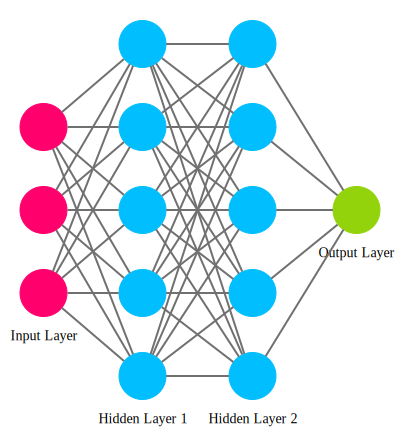

In [ ]:
net = Network(n_features=3, hidden_size=5, num_layers=2)
visualize(net)

## Section 1.1: Adding NN layers for prediction

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is an ordered
container of modules. The data is passed through all the modules in the same order as defined. You can use
sequential containers to put together a quick network like ``seq_modules``.

In [ ]:
class MLP(nn.Module):

  # Multilayer Perceptron for regression.

  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(

      # Add linear input layer
      nn.Linear(n_features, 64),
      nn.ReLU(),

      # Add one hidden layer with 64 neurons
      nn.Linear(64,64),

      # Add ReLU activation function
      nn.ReLU(),

      # Add linear output layer
      nn.Linear(64, 1)
    )

  def forward(self, x):
    # Forward pass
    return self.layers(x)

We create an instance of ``NeuralNetwork``, and move it to the ``device``, and print
its structure.

In [ ]:
model = MLP().to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process.
Different hyperparameter values can impact model training and convergence rates
([read more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)_ about hyperparameter tuning)

We define the following hyperparameters for training:
 - **Number of Epochs** - the number times to iterate over the dataset
 - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
 - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [ ]:
learning_rate = 1e-3
batch_size = 32
epochs = 10

### Loss Function

When presented with some training data, our untrained network is likely not to give the correct
answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value,
and it is the loss function that we want to minimize during training. To calculate the loss we make a
prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) for regression tasks, and
[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification.
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines ``nn.LogSoftmax`` and ``nn.NLLLoss``.

We pass our model's output to loss function. This will compute the shot prediction error.

In [ ]:
# Initialize the loss function MSELoss()
loss_function = nn.MSELoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent).
All optimization logic is encapsulated in  the ``optimizer`` object. Here, we use the SGD optimizer; additionally, there are many [different optimizers](https://pytorch.org/docs/stable/optim.html)
available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Datasets & DataLoaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code
to be decoupled from our model training code for better readability and modularity.
PyTorch provides two data primitives: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``
that allow you to use pre-loaded datasets as well as your own data.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset`` to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that
subclass ``torch.utils.data.Dataset`` and implement functions specific to the particular data.
They can be used to prototype and benchmark your model. You can find them
here: [Image Datasets](https://pytorch.org/vision/stable/datasets.html),
[Text Datasets](https://pytorch.org/text/stable/datasets.html), and
[Audio Datasets](https://pytorch.org/audio/stable/datasets.html)

### Custom dataset class - to convert Pandas dataframes to PyTorch tensors for NN

In [ ]:
class BostonDataset(torch.utils.data.Dataset):
  # Prepare the Boston dataset for regression

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):

      # TODO: Apply scaling to input features

      if scale_data:
        # Apply scaling to feature inputs
        # Standardize features by removing the mean and scaling to unit variance
        X = StandardScaler().fit_transform(X)

      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [ ]:
## If we want, we can set the random seed to get the same training results every time
torch.manual_seed(0)

In [ ]:
# Prepare Boston datasets
dataset_train = BostonDataset(X_train.values, y_train.values)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)

# Prepare test dataset
dataset_test = BostonDataset(X_test.values, y_test.values)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=1)

## Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each
iteration of the optimization loop is called an **epoch**.

Each epoch consists of two main parts:
 - **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.
 - **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

Let's briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to
see the `full-impl-label` of the optimization loop.

Inside the training loop, optimization happens in three steps:
 * Call ``optimizer.zero_grad()`` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 * Backpropagate the prediction loss with a call to ``loss.backward()``. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 * Once we have our gradients, we call ``optimizer.step()`` to adjust the parameters by the gradients collected in the backward pass.

## Section 1.2: Run the training loop

In [ ]:
# Run the training loop
for epoch in range(epochs): # 5 epochs at maximum

  # Print epoch
  print(f'Starting epoch {epoch+1}')

  # Iterate over the DataLoader for training data
  for batch, (inputs, targets) in enumerate(trainloader, 0):

    num_batches = len(trainloader)
    size = len(trainloader.dataset)

    # Prepare inputs
    inputs, targets = inputs.float(), targets.float()

    # To account for GPU
    inputs, targets = inputs.to(device), targets.to(device)

    targets = targets.reshape((targets.shape[0], 1))

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = model(inputs)

    # Compute loss
    loss = loss_function(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Print statistics

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    # NOTE: .item() here moves the data from the GPU to CPU, since numpy only works with CPUs.

# Process is complete.
print('Training process has finished.')

Starting epoch 1
loss: 773.212769  [    0/  339]
Starting epoch 2
loss: 424.148315  [    0/  339]
Starting epoch 3
loss: 68.464951  [    0/  339]
Starting epoch 4
loss: 48.804573  [    0/  339]
Starting epoch 5
loss: 54.996292  [    0/  339]
Starting epoch 6
loss: 15.357870  [    0/  339]
Starting epoch 7
loss: 13.304148  [    0/  339]
Starting epoch 8
loss: 31.994642  [    0/  339]
Starting epoch 9
loss: 15.009954  [    0/  339]
Starting epoch 10
loss: 28.844593  [    0/  339]
Training process has finished.


### Testing loop

In [ ]:
size = len(testloader.dataset)
num_batches = len(testloader)
model.eval()
test_loss = 0

test_loss = 0

with torch.no_grad():
    for inputs, targets in testloader:

      inputs, targets = inputs.float(), targets.float()

      # To account for GPU
      inputs, targets = inputs.to(device), targets.to(device)

      targets = targets.reshape((targets.shape[0], 1))

      # Get prediction
      outputs = model(inputs)

      # Compute loss
      test_loss += loss_function(outputs, targets).item()

test_loss /= num_batches
print(f"Avg loss: {test_loss:>8f} \n")

Avg loss: 17.421546 



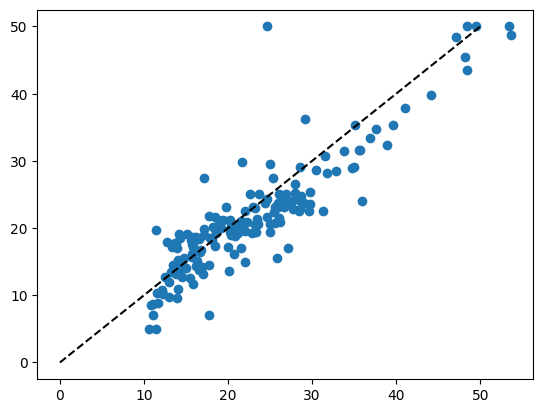

In [ ]:
y_pred = []
y_true = []
net.train(False)
for inputs, targets in testloader:
  inputs, targets = inputs.float(), targets.float()

  # To account for GPU
  inputs, targets = inputs.to(device), targets.to(device)

  targets = targets.reshape((targets.shape[0], 1))

  outputs = model(inputs)
  y_pred.extend(model(inputs).data.numpy())
  y_true.extend(targets.numpy())
plt.scatter(y_pred, y_true)
plt.plot([0, 50], [0, 50], '--k')

# Section 2: CNNs: MNIST Hand-Written Digit Recognition

In this section, we'll use CNNs for image classification tasks

###First, let's use Pytorch to download MNIST data in a useful format and create a DataLoader.

In [ ]:
data_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('sample_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=True)

### **Exercise 2:** Let's look at some of the images! Run the cells below a few times to show randomly selected images

In [ ]:
from PIL import Image
from io import BytesIO
import IPython.display

def show_random_image():
  dataset = np.array(data_loader.dataset.data)
  num_images = dataset.shape[0]
  image_idx = np.random.randint(low=0, high=num_images)
  pil_image = Image.fromarray(np.array(data_loader.dataset.data[image_idx]))
  height, width = pil_image.size
  pil_image = pil_image.resize((height * 10, width * 10))
  f = BytesIO()
  pil_image.save(f, 'png')
  IPython.display.display(IPython.display.Image(data=f.getvalue()))


Showing 5 random images:


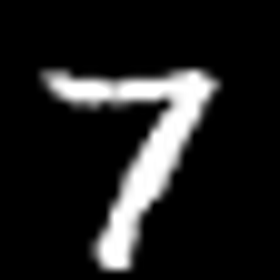

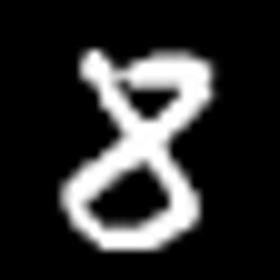

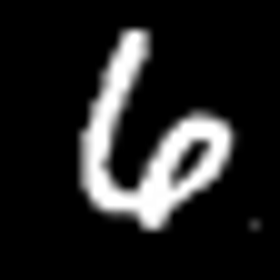

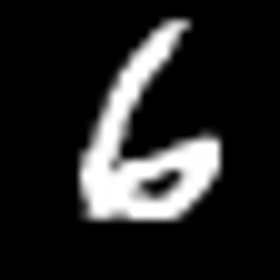

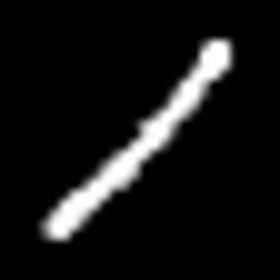

In [ ]:
num_images_to_show = 5
print(f'Showing {num_images_to_show} random images:')
for display_idx in range(num_images_to_show):
  show_random_image()
  print()

### Second, let's set some hyperparameters for training. We can play around with these more, later.

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

#### Next, let's make some data loaders. We will use PyTorch's pre-built dataloaders so we don't have to build our own.

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('sample_data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('sample_data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

## Section 2.1 MNIST Classification with Fully Connected Networks!
Let's try classifying hand-written digits with fully connected networks -- just like the ones you visualized up above.

First, let's make our neural network.

In [ ]:
class FullyConnectedNetwork(nn.Module):
  def __init__(self, n_features=784, hidden_size=32):
    super().__init__()
    self.layer0 = nn.Linear(n_features, hidden_size)

    # Add another hidden layer with 10 neurons
    self.layer1 = nn.Linear(hidden_size, 10)

  def forward(self, input_data):
    # Fill in the code for the forward pass
    # Apply ReLU activation after 1st input layer
    x = F.relu(self.layer0(input_data))

    # Apply 2nd layer
    x = self.layer1(x)

    # Apply log_softmax activation for last layer & then return outputs
    return F.log_softmax(x)

In [ ]:
# Create an instance of the above NN
fc_network = FullyConnectedNetwork()

# Pass model to device (CPU or GPU)
fc_network.to(device)

# Print model architecture
print(fc_network)

FullyConnectedNetwork(
  (layer0): Linear(in_features=784, out_features=32, bias=True)
  (layer1): Linear(in_features=32, out_features=10, bias=True)
)


In [ ]:
# Our optimizer will use Stochastic Gradient Descent to train our network
# Set optimizer to SGD with the above learning_rate and momentum hyperparameters
# We'll be cover these parameters in more detail tomorrow
fc_optimizer = optim.SGD(fc_network.parameters(), lr=learning_rate, momentum=momentum)

## Model Layers

Let's break down the layers in the FashionMNIST model. To illustrate it, we
will take a sample minibatch of 3 images of size 28x28 and see what happens to it as
we pass it through the network.

In [ ]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### nn.Flatten

Since we're using a fully connected network for the 1st model,
We initialize the [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784 pixel values (
the minibatch dimension (at dim=0) is maintained).

In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear
The [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its stored weights and biases.

In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### nn.ReLU
Non-linear activations are what create the complex mappings between the model's inputs and outputs.
They are applied after linear transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) between our
linear layers, but there's other activations to introduce non-linearity in your model.

In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 4.4176e-01, -8.1927e-04, -4.4663e-02,  2.9619e-01,  2.5046e-01,
         -5.7961e-01,  4.0592e-01,  3.2938e-01, -6.2028e-01,  1.8992e-01,
         -2.8489e-01, -5.0871e-02,  4.3112e-01, -2.0824e-01,  2.1958e-01,
         -2.7955e-01, -9.3912e-02,  1.0144e-01,  2.2358e-01,  1.1241e-02],
        [ 3.7187e-01,  3.5274e-01, -2.5956e-01,  2.4720e-01, -4.5632e-03,
         -4.9264e-01,  3.9579e-01,  5.9836e-02, -3.8167e-01, -1.1238e-01,
         -2.7552e-01, -5.0454e-01,  4.4484e-01, -4.0995e-01, -1.7151e-01,
          1.2933e-01,  1.1447e-01, -4.6520e-02,  5.8720e-01, -9.0402e-02],
        [ 3.2637e-01,  5.0160e-02, -3.2399e-01,  1.0417e-01,  4.1837e-01,
         -5.4401e-01,  8.3621e-01, -1.0418e-02, -5.7780e-01, -1.3974e-01,
         -3.0365e-01, -1.8801e-01,  5.3220e-01, -2.1159e-01, -4.8945e-02,
          1.6585e-02, -2.4605e-04, -1.2065e-01,  2.5094e-01, -2.7647e-01]],
       grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.4418, 0.0000, 0.0000, 0.2962, 0.2505,

### nn.Sequential
[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is an ordered
container of modules. The data is passed through all the modules in the same order as defined. You can use
sequential containers to put together a quick network like ``seq_modules``.

In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

### nn.Softmax
The last linear layer of the neural network returns `logits` - raw values in [-$\infty, \infty$] which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) module. The logits are scaled to values
[0, 1] representing the model's predicted probabilities for each class. ``dim`` parameter indicates the dimension along
which the values must sum to 1.

In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

## Section 2.2 Now let's make some functions to help us train and evaluate

In [ ]:
# Note: network.train() puts the network into "nondeterministic mode".
# This doesn't matter for the fully connected network, but will matter for the convolutional network
def train(network, optimizer, epoch, flatten_data=True):
  network.train()
  loss_logs = list()

  for batch_idx, (data, target) in enumerate(train_loader):
    if flatten_data:
      data = flatten(data)

    num_batches = len(trainloader)
    size = len(trainloader.dataset)

    # To account for GPU
    data, target = data.to(device), target.to(device)


    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    output = network(data)

    # Compute loss - Use the negative log likelihood loss function
    loss = F.nll_loss(output, target)

    # Perform backpropagation - gradient update
    loss.backward()

    # Perform optimization
    optimizer.step()

    # print an update
    if batch_idx % log_interval == 0:
      examples_shown = batch_idx * len(data)
      total_examples = len(train_loader.dataset)
      fraction_shown = round(examples_shown / total_examples * 100., 2)
      rounded_loss = round(loss.item(), 4)
      print(f'Train Epoch {epoch} Progress: {fraction_shown}%\tLoss: {rounded_loss}')

      examples_so_far = batch_idx*batch_size_train + epoch*len(train_loader.dataset)
      loss_logs.append((examples_so_far, loss.item()))
  return loss_logs

  Observe how gradient buffers had to be manually set to zero using
  ``optimizer.zero_grad()``. This is because gradients are accumulated due to back propagation.

### **Exercise 3**: Here we used the negative log-likelihood loss function. What are some [other loss functions](https://https://pytorch.org/docs/stable/nn.html#loss-functions) we could use for such multi-class classification?

*SOLUTION*: Some possible answers: Cross entropy loss, Multi margin loss, multi label margin loss

In [ ]:
def test(network,flatten_data=True):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      if flatten_data:
        data = flatten(data)

      # To account for GPU
      data, target = data.to(device), target.to(device)

      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  accuracy = round(100. * correct.item() / len(test_loader.dataset), 2)
  print(f'\nTest set: Avg loss {round(test_loss, 4)}, Accuracy {accuracy}%\n')
  return test_loss, accuracy

## Now we're ready to train! Run the cell below to train your fully connected network.

In [ ]:
test_accuracies, test_losses, train_losses = list(), list(), list()
total_examples_seen = 0
for epoch in range(n_epochs):
  test_loss, test_accuracy = test(fc_network)
  train_loss_logs = train(fc_network, fc_optimizer, epoch)
  # logging
  test_accuracies.append((epoch, test_accuracy))
  test_losses.append((total_examples_seen, test_loss))
  train_losses.extend((train_loss_logs))
  total_examples_seen = train_loss_logs[-1][0]
test_loss, test_accuracy = test(fc_network)
test_accuracies.append((n_epochs, test_accuracy))
test_losses.append((total_examples_seen, test_loss))


Test set: Avg loss 2.348, Accuracy 8.02%

Train Epoch 0 Progress: 0.0%	Loss: 2.3537
Train Epoch 0 Progress: 1.07%	Loss: 2.1409
Train Epoch 0 Progress: 2.13%	Loss: 1.8337
Train Epoch 0 Progress: 3.2%	Loss: 1.5168
Train Epoch 0 Progress: 4.27%	Loss: 1.3242
Train Epoch 0 Progress: 5.33%	Loss: 1.1885
Train Epoch 0 Progress: 6.4%	Loss: 1.0954
Train Epoch 0 Progress: 7.47%	Loss: 0.8399
Train Epoch 0 Progress: 8.53%	Loss: 0.841
Train Epoch 0 Progress: 9.6%	Loss: 0.6054
Train Epoch 0 Progress: 10.67%	Loss: 0.7435
Train Epoch 0 Progress: 11.73%	Loss: 0.6648
Train Epoch 0 Progress: 12.8%	Loss: 0.4518
Train Epoch 0 Progress: 13.87%	Loss: 0.6083
Train Epoch 0 Progress: 14.93%	Loss: 0.5449
Train Epoch 0 Progress: 16.0%	Loss: 0.6261
Train Epoch 0 Progress: 17.07%	Loss: 0.6638
Train Epoch 0 Progress: 18.13%	Loss: 0.3303
Train Epoch 0 Progress: 19.2%	Loss: 0.4443
Train Epoch 0 Progress: 20.27%	Loss: 0.5587
Train Epoch 0 Progress: 21.33%	Loss: 0.523
Train Epoch 0 Progress: 22.4%	Loss: 0.3718
Train Epo

## Let's visualize the results! 📈

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(test_accuracies, test_losses, train_losses):
  # plot training losses and test losses together
  training_x_values = [x[0] for x in train_losses]
  training_losses = [x[1] for x in train_losses]
  plt.plot(training_x_values, training_losses)
  test_x_values = [x[0]  for x in test_losses]
  test_loss_values = [x[1] for x in test_losses]
  plt.plot(test_x_values, test_loss_values, linestyle='--', marker='o', color='r')
  # plt.scatter(test_x_values, test_loss_values, color='r')
  plt.ylabel('Log loss')
  plt.xlabel('Examples seen')
  plt.show()

  # Next, plot test accuracy over time
  test_accuracy_x_values = [x[0] for x in test_accuracies]
  test_accuracy_values = [x[1] for x in test_accuracies]
  plt.plot(test_accuracy_x_values, test_accuracy_values, color='g', marker='o')
  plt.ylabel('Test Accuracy')
  plt.xlabel('Epochs')

### **Exercise 4:** Generate and inspect the accuracy and loss graphs. Are these what you would expect? If you continued training for longer, what would you expect? Try it!

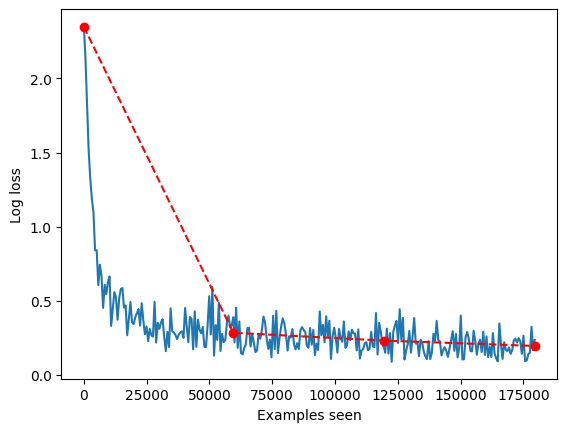

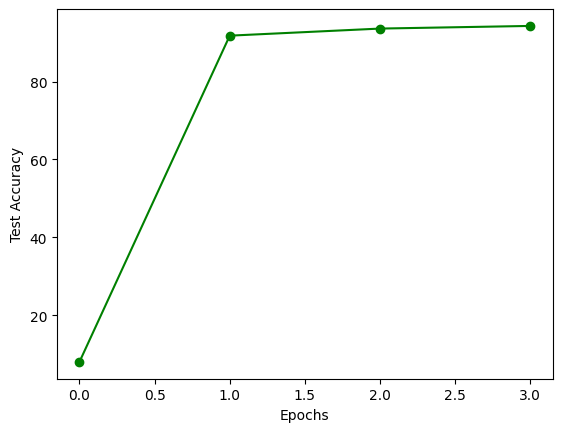

In [ ]:
plot_results(test_accuracies, test_losses, train_losses)

*SOLUTION*: This should be about what you expect, and with more training you could expect slightly better performance over time but the performance will not reach 99% or 100%. This may also lead to overfitting since the model seems to already be a pretty good fit with low loss and high accuracy. Overfitting would result in lower training errors but poorer performance on the test set.

### **Exercise 5:** If you were using a fully connected network to solve a real-world problem, would you use this neural architecture or would you change something? What would you change and why?

*SOLUTION*: Generally, this architecture with more training time and better hyperparameters would be the best solution, especially on mobile devices and low-resource computing settings because it performs very well, and is a very small architecture. However, if you have lots of compute, you could experiment with larger architectures that might get slightly better performance.

## Section 2.3: Let's do it again with a Convolutional Network! There might be some layers you don't recognize, such as "dropout" and "max pooling". Don't worry about those for now!

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 1 input image channel, 10 output channels, 5x5 square convolution
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

        # Add another convolutional layer with 20 output channels & 5x5 kernel
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        self.conv2_drop = nn.Dropout2d()

        # Add linear layer with 320 inputs & 50 outputs
        self.fc1 = nn.Linear(320, 50)

        # Add linear layer with 50 inputs & 10 outputs
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # Apply the 2nd Conv layer followed by dropout
        x = self.conv2_drop(self.conv2(x))

        # Apply max pooling with size of the pooling region (kernel) = 2
        x = F.max_pool2d(x, 2)

        # Apply ReLU activation
        x = F.relu(x)

        x = x.view(-1, 320)

        # TODO: Apply the 1st linear layer
        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training)

        # Apply the last linear layer
        x = self.fc2(x)

        # Return categorical probability distribution (calculate log(softmax))
        return F.log_softmax(x)

Let's establish our hyperparameters again so we don't have to scroll all the way up

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [ ]:
# Initialize network instance
conv_network = ConvNet()

# Pass to device (CPU or GPU)
conv_network.to(device)

# Use SGD optimizer with custom learning rate, momentum
conv_optimizer = optim.SGD(conv_network.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
test_accuracies, test_losses, train_losses = list(), list(), list()
total_examples_seen = 0
for epoch in range(n_epochs):
  test_loss, test_accuracy = test(conv_network, flatten_data=False)
  train_loss_logs = train(conv_network, conv_optimizer, epoch, flatten_data=False)
  # logging
  test_accuracies.append((epoch, test_accuracy))
  test_losses.append((total_examples_seen, test_loss))
  train_losses.extend((train_loss_logs))
  total_examples_seen = train_loss_logs[-1][0]
test_loss, test_accuracy = test(fc_network)
test_accuracies.append((n_epochs, test_accuracy))
test_losses.append((total_examples_seen, test_loss))


Test set: Avg loss 2.3023, Accuracy 9.6%

Train Epoch 0 Progress: 0.0%	Loss: 2.2812
Train Epoch 0 Progress: 1.07%	Loss: 2.2759
Train Epoch 0 Progress: 2.13%	Loss: 2.3073
Train Epoch 0 Progress: 3.2%	Loss: 2.2866
Train Epoch 0 Progress: 4.27%	Loss: 2.2571
Train Epoch 0 Progress: 5.33%	Loss: 2.2621
Train Epoch 0 Progress: 6.4%	Loss: 2.2899
Train Epoch 0 Progress: 7.47%	Loss: 2.1922
Train Epoch 0 Progress: 8.53%	Loss: 2.1272
Train Epoch 0 Progress: 9.6%	Loss: 2.1906
Train Epoch 0 Progress: 10.67%	Loss: 2.1054
Train Epoch 0 Progress: 11.73%	Loss: 1.9752
Train Epoch 0 Progress: 12.8%	Loss: 1.8455
Train Epoch 0 Progress: 13.87%	Loss: 1.6734
Train Epoch 0 Progress: 14.93%	Loss: 1.6812
Train Epoch 0 Progress: 16.0%	Loss: 1.6865
Train Epoch 0 Progress: 17.07%	Loss: 1.5038
Train Epoch 0 Progress: 18.13%	Loss: 1.4785
Train Epoch 0 Progress: 19.2%	Loss: 1.3037
Train Epoch 0 Progress: 20.27%	Loss: 1.3447
Train Epoch 0 Progress: 21.33%	Loss: 1.2811
Train Epoch 0 Progress: 22.4%	Loss: 0.9318
Train E

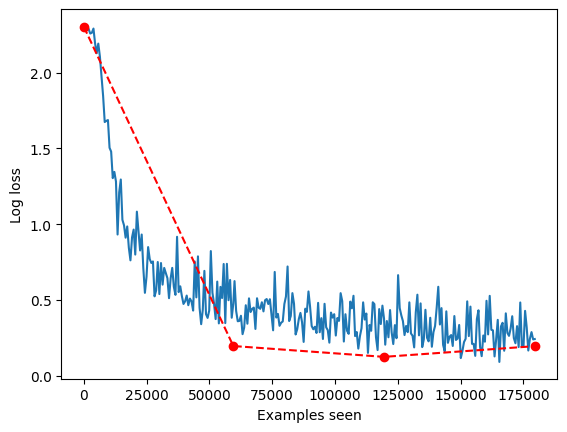

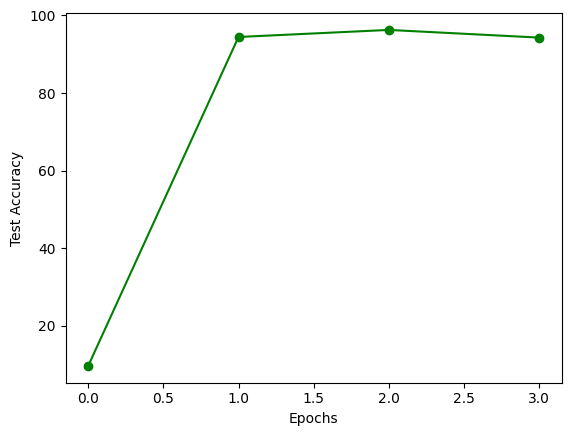

In [ ]:
# Visualize training and testing results
plot_results(test_accuracies, test_losses, train_losses)

## **Exercise 5:** Compare the results of the convolutional network to the fully connected network. What do you notice? Which would you choose if you were solving a real-world problem, and why?

*SOLUTION*: The convolutional network is likely to perform trivially better. In a real-world situation, you would likely be able to get the same performance with a well-tuned fully connected network. If you spent a lot of time hyperparameter tuning, you could maybe get very slightly better performance from the convolutional network.

## **Exercise 6**: If we were solving a much harder classification problem, such as classifying Pneumonia Chest X-Ray images, how do you think that the convolutional network's performance would compare to the fully connected network's performance? Why?

*SOLUTION*: You would expect the convolutional network to perform much better because it's able to extract features from patches of pixels more effectively and learn more abstract features better.

Credits: credit to https://nextjournal.com/gkoehler/pytorch-mnist for providing inspiration for part of this tutorial

## Saving Models
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [ ]:
torch.save(conv_network.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [ ]:
model = ConvNet()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



In [ ]:
# Download test data from open datasets.
test_data = datasets.MNIST('sample_data/',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

classes = [1, 2, 3, 4, 5, 6, 7, 8, 9]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "8", Actual: "8"


# Section 3: RNN for MNIST Digit Image Classification

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vSiMstqkE9hTYmhPD3KMeFRNNKYA2NnrCayahBOEL1TalRqaWF7rH8a7O-nP9c-mKOdZRsWtmAGZfNN/pub?w=969&h=368)

Let's try to build an image classifier using the MNIST dataset based on a recurrent neural network (RNN) instead of a CNN. The MNIST dataset consists of images that contain hand-written numbers from 1–10. Essentially, we want to build a classifier to predict the numbers displayed by a set of images. I know this sounds strange but you will be surprised by how well RNNs perform on this image classification task.

RNNs are a family of networks that are suitable for learning representations of sequential data like text in natural language processing (NLP) or a stream of sensor data in instrumentation. While each MNIST data sample is not sequential in nature, it is not hard to imagine that **every image can be interpreted as a sequence of rows or columns of pixels (28 x 28). Thus, a model based on RNNs can process each MNIST image as a sequence of 28-element input vectors with timesteps equal to 28**.

We will also be using the [RNN module](https://https://pytorch.org/docs/stable/nn.html#recurrent-layers) - We will only use **one layer** in the following computation graph, but you can experiment with the code later on by adding more layers.

## Importing the dataset
Before building the RNN-based computation graph, let's import the MNIST dataset, split it into test and train portions, do a few transformations, and further explore it. You will need the following PyTorch libraries and lines of code to download and import the MNIST dataset to Google Colab.

In [ ]:
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

The code above loads and prepares the dataset to be fed into the computation graph we will build later on. Take a few minutes to play around with the code and understand what is happening. Notice that we needed to provide a batch size. This is because `trainloader` and `testloader` are iterators which will make it easier when we are iterating on the dataset and training our RNN model with minibatches.

## Exploring the dataset
Here is a few lines of code to explore the dataset. I won't cover much of what's going on here, but you can take some time and look at it by yourself.

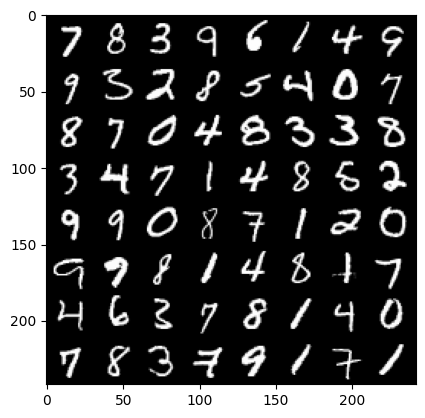

In [ ]:
# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Model
Let's construct the computation graph. Below are the parameters:

In [ ]:
# parameters
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPOCHS = 10

And finally, here is a figure of the RNN-based classification model we are building:

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vQWhELhewvq_bHgqwf4vwDb5B9DN9-jAxeTF9Y73zr-OsW6OXC-ngxAfojivXyZEhjzLXceTZU2Ncz3/pub?w=550&h=600)

And here is the code for the model. The `ImageRNN` model below is doing the following:
- The initialization function `__init__(...)` declares a few variables, and then a [basic RNN layer](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) `basic_rnn` followed by a fully-connected layer `self.FC`.
- The `init_hidden` function initializes hidden weights with zero values.
The `forward` function accepts an input of size `n_steps X batch_size X n_neurons`. Then the data flows through the RNN layer and then through the fully-connected layer.
- The output are the log probabilities of the model.

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()

        self.n_neurons = n_neurons # no. of neurons in each hidden layer
        self.batch_size = batch_size
        self.n_steps = n_steps # Sequence length
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # Add RNN layer of size: n_inputs x n_neurons
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons)

        # Add hidden output layer after RNN
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)

    def init_hidden(self,):
        # Initialize & return a torch tensor of zeros
        # with size (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))

    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2)

        self.batch_size = X.size(1)

        # Set initial hidden state (h_0)
        self.hidden = self.init_hidden()

        # Inputs to RNN = X (inputs), h_0

        # Outputs of RNN
        # rnn_out shape => (n_steps, batch_size, n_neurons) - final state/outputs from the last layer of the RNN
        # self.hidden shape => (1, batch_size, n_neurons) - hidden state for each time step

        # Compute outputs of RNN
        rnn_out, self.hidden = self.basic_rnn(X, self.hidden)

        # Compute final output by applying FC layer
        out = self.FC(self.hidden)

        return out.view(-1, self.n_outputs) # batch_size X n_output

## Testing the model with some samples
A very good practice encouraged by PyTorch developers throughout their documentation, and which I really like and highly recommend, is to always test the model with a portion of the dataset before actual training. This is to ensure that you have the correct dimension specified and that the model is outputing the information you expect. Below I show an example of how to test your model:

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create instance of ImageRNN model
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)

logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.1327,  0.0276, -0.0692, -0.0852, -0.1019, -0.0215, -0.0796,  0.0534,
         -0.0118,  0.0582],
        [ 0.1150,  0.0239, -0.0845, -0.0804, -0.1108, -0.0222, -0.0761,  0.0499,
         -0.0195,  0.0513],
        [ 0.1425,  0.0396, -0.0784, -0.0974, -0.0971, -0.0230, -0.0643,  0.0729,
         -0.0161,  0.0618],
        [ 0.1391,  0.0162, -0.0794, -0.1015, -0.0928, -0.0109, -0.0833,  0.0355,
         -0.0008,  0.0484],
        [ 0.1158,  0.0258, -0.0858, -0.0812, -0.1078, -0.0214, -0.0757,  0.0504,
         -0.0229,  0.0476],
        [ 0.1157,  0.0283, -0.0847, -0.0785, -0.1021, -0.0234, -0.0729,  0.0513,
         -0.0257,  0.0510],
        [ 0.1140,  0.0349, -0.0801, -0.0830, -0.1107, -0.0175, -0.0770,  0.0566,
         -0.0097,  0.0454],
        [ 0.1179,  0.0246, -0.0822, -0.0772, -0.1038, -0.0182, -0.0772,  0.0419,
         -0.0176,  0.0478],
        [ 0.1131,  0.0265, -0.0857, -0.0795, -0.1048, -0.0162, -0.0720,  0.0462,
         -0.0212,  0.0570],
        [ 0.1236,  

## Training

Now let's look at the code for training the image classification model. But first, let's declare a few helper functions needed to train the model:

Before training a model in PyTorch, you can programatically specify what device you want to use during training; the `torch.device(...)` function tells the program that we want to use the GPU if one is available, otherwise the CPU will be the default device.

Then we create an instance of the model, `ImageRNN(...)``, with the proper parameters. The criterion represents the function we will use to compute the loss of the model. The `nn.CrossEntropyLoss()` function basically applies a log softmax followed by a negative log likelihood loss operation over the output of the model. To compute the loss, the function needs both the log probabilities and targets. We will see later in our code how to provide this to the criterion.

For training, we also need an optimization algorithm which helps to update weights based on the current loss. This is achieved with the `optim.Adam` optimization function, which requires the model parameters and a learning rate. Alternatively, you can also use `optim.SGD` or any other optimization algorithm that's available.

The `get_accuracy(...)` function simply computes the accuracy of the model given the log probabilities and target values. As an exercise, you can write code to test this function as we did with the model before.

Let's put everything together and train our image classification model:

In [ ]:
# Create model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)

# Pass to device (CPU or GPU)
model.to(device)

# Use CrossEntropyLoss function
loss_function = nn.CrossEntropyLoss()

# Set Adam optimizer with learning rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0 # Training accuracy
    model.train()

    # TRAINING ROUND
    for i, data in enumerate(trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # reset hidden states to zero
        model.hidden = model.init_hidden()

        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28)

        # To account for CPU or GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Finish code for forward pass, backpropagation & optimization
        outputs = model(inputs)

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()

        # Increment training accuracy
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f'
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7710 | Train Accuracy: 74.81
Epoch:  1 | Loss: 0.3247 | Train Accuracy: 90.64
Epoch:  2 | Loss: 0.2282 | Train Accuracy: 93.48
Epoch:  3 | Loss: 0.1880 | Train Accuracy: 94.74
Epoch:  4 | Loss: 0.1641 | Train Accuracy: 95.34
Epoch:  5 | Loss: 0.1569 | Train Accuracy: 95.61
Epoch:  6 | Loss: 0.1378 | Train Accuracy: 96.08
Epoch:  7 | Loss: 0.1264 | Train Accuracy: 96.43
Epoch:  8 | Loss: 0.1239 | Train Accuracy: 96.54
Epoch:  9 | Loss: 0.1200 | Train Accuracy: 96.62


## Testing

We can also compute accuracy on the testing dataset to test how well the model performs on the image classification task. As you can see below, our RNN model is performing very well on the MNIST classification task.


In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    # To account for GPU
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.18


# Section 4: Extra challenge exercises (Optional)

### **Challenge Exercise 1:** Change the fully connected neural network architecture. Increase the number of hidden units per layer to 100 and add 2 more hidden layers, then retrain. How does the training compare to the previous architecture?

*SOLUTION:* In this case it trains slightly better than the default architecture. Solution code is below.

In [ ]:

class BiggerFullyConnectedNetwork(nn.Module):
  def __init__(self, n_features=784, hidden_size=100):
    super().__init__()
    self.layer0 = nn.Linear(n_features, hidden_size)
    self.layer1 = nn.Linear(hidden_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.layer3 = nn.Linear(hidden_size, 10)

  def forward(self, input_data):
    x = F.relu(self.layer0(input_data))
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)
    return F.log_softmax(x)



##**Challenge Exercise 2:** With this larger architecture, try training for significantly more epochs--perhaps 30 or 40. What problems might this run into? What if you made the network even larger -- what problems could you encounter then?

*SOLUTION*: You would quickly expect overfitting problems.


##**Challenge Exercise 3:** Experiment with the fully connected and convolutional network architectures and hyperparameters. How high of a test accuracy can you achieve? Write down the highest test accuracy you're able to get and submit it to the Slack channel!

*Solution*: With just a few minutes of tuning, they should be able to get >97% accuracy. Let's see how well they can do this